This might be a little messy. Apologies for some unnecessary junk and lack of streamlining. I copied most of the curve_fit and FFT from outside, so I can of course clean this up significantly given more time, but this is just proof of concept. I did my best to match the scale of current and time from the graph you gave me, assuming Amperes vs seconds.

Approach:

1.A Collect data from input signal (delayed until after warmup?)

1.B Plot data with and without noise (only applies to pre-generated data)

2.A Quantify initial data parameters using Fourier and curve_fit analysis

2.B Plot fitted curve against initial data

3.A Quantify new parameters using same analysis techniques.

3.B Plot new data waveform against initial data waveform

4.A Plot/analyze differences in waveforms using amplitude

4.B Plot/analyze differences in waveforms using slope ----> for later. no time to do that today.

4.C Plot/analyze differences in waveforms using phase

5.A Plot/analyze first derivatives of data sets

5.B Plot/analyze second derivatives of data sets

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets #I considered putting in sliders to adjust event location and other things, but haven't done that yet.
import scipy.optimize as scopt

interactive(children=(FloatSlider(value=2.0, description='mid', max=2.5, min=1.5, step=0.01), IntSlider(value=…

A=10.711838769431711, w=372.79649985836227, p=1.4297841020145607, c=-1.7867199220537826, unc2=0.5877170780229041


interactive(children=(IntSlider(value=50, description='ymax', min=1), Output()), _dom_classes=('widget-interac…

A2=11.83533292384828, w2=407.1330221784434, p2=0.40242120459172814, c2=-2.0122890750246016, unc=4.282951985454279


interactive(children=(IntSlider(value=50, description='ymax', min=1), Output()), _dom_classes=('widget-interac…

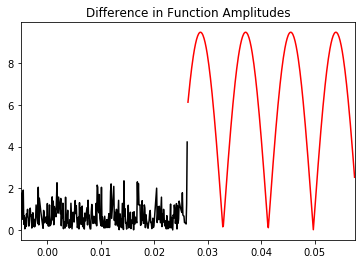

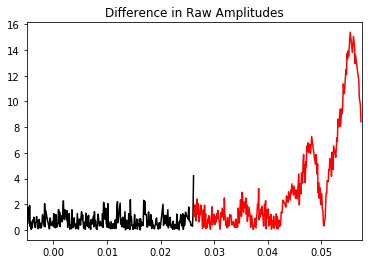

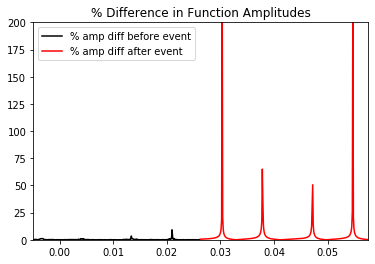

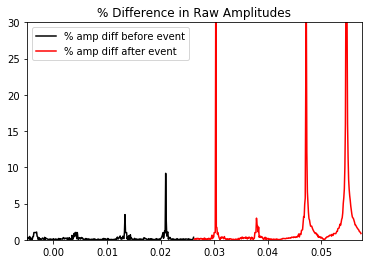

In [69]:
#1.A

time, trigSig, brakeF, current, voltage = np.loadtxt('MAKESafe/Scope_Data_02.13.2020_minus_header.csv',delimiter=',',usecols=(0,1,2,3,4),unpack=True)

def tRat(mid,leng,ymax):
    begPoint = int(len(time)*(1/mid-1/leng))
    midpoint = int(len(time)/mid)
    curPoint = int(len(time)*(1/mid+1/leng))
    length = int(len(time)*1/(leng*100))
#    tBeg = time[begPoint]
    tMid = time[midpoint] 
    tCur = time[curPoint] #"most recent" time
    print(begPoint, midpoint, curPoint, length, tBeg, tMid,tCur)

    tt = np.linspace(begPoint,midpoint,length)
    for i in range (0,length):
        tt[i] = time[100*i+begPoint]
    
    tt2 = np.linspace(midpoint,curPoint,length)
    for i in range (0,length):
        tt2[i] = time[(100*i)+midpoint]
    
    yy = np.linspace(begPoint,midpoint,length)
    for i in range (0,length):
        yy[i-1] = current[100*i+begPoint]
    
    yy2 = np.linspace(midpoint,curPoint,length)
    for i in range (0,length):
        yy2[i] = current[100*i+midpoint]
    
    plt.plot(tt, yy, "-b", label="y", linewidth=2)
    plt.plot(tt2, yy2, "-b", label="y", linewidth=2)
    plt.legend(loc="best")
    plt.xlim(tBeg,tCur)
    plt.ylim(-ymax,ymax)
    plt.title("The Initial Data")
    plt.show()

widgets.interact(tRat,mid=(1.5,2.5,.01),leng=(16,64,1),ymax=(1,100,1))

#2.A
def sinCurve(t, A, w, p, c):  
    return A * np.sin(w*t + p) + c

def fit_sin(tt, yy):
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    popt, pcov = scopt.curve_fit(sinCurve, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

#2.B

res = fit_sin(tt, yy)
print( "A=%(amp)s, w=%(omega)s, p=%(phase)s, c=%(offset)s, unc2=%(maxcov)s" % res )

def initialFit(ymax):
    plt.plot(tt, yy, "-b", label="y", linewidth=2)
    plt.legend(loc="best")
    plt.plot(tt, res["fitfunc"](tt), "r-", label="y fit curve", linewidth=2)
    plt.title("The Initial Curve Fit")
    plt.xlim(tBeg,tCur)
    plt.ylim(-ymax,ymax)
    plt.show()

widgets.interact(initialFit,ymax=(1,100,1))   

#3.A CHANGE IN PHASE

def fit_sin_new(tt, yy):
    tt = np.array(tt2)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    popt, pcov = scopt.curve_fit(sinCurve, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp2": A, "omega2": w, "phase2": p, "offset2": c, "freq2": f, "period2": 1./f, "fitfunc2": fitfunc, "maxcov2": np.max(pcov), "rawres2": (guess,popt,pcov)}

res2 = fit_sin_new(tt2, yy2)
print( "A2=%(amp2)s, w2=%(omega2)s, p2=%(phase2)s, c2=%(offset2)s, unc=%(maxcov2)s" % res2 )

#3.B

def initialFit(ymax):
    plt.plot(tt, yy, "-b", label="y", linewidth=2)
    plt.plot(tt2, yy2, "-b", label="y post event")
    plt.legend(loc="best")
    plt.plot(tt, res["fitfunc"](tt), "r-", label="y fit curve", linewidth=2)
    plt.plot(tt2, res["fitfunc"](tt2), "r-", label="y fit curve", linewidth=2)
    plt.plot(tt2, res2["fitfunc2"](tt2), "g-", label="new y fit curve", linewidth=2)
    plt.title("The New Curve Fit")
    plt.xlim(tBeg,tCur)
    plt.ylim(-ymax,ymax)
    plt.show()

widgets.interact(initialFit,ymax=(1,100,1))

#4.A FAULT DETECTION: AMPLITUDE

ampSens = 5 #Input = sensitivity level (in Amperes). ~1A is fine.
percAmpSens = 1000 #Input = Sensitivity factor (in percentage). Anything above ~2% is fine for larger data sets.

def ampDiff(a,b):
    return np.abs(a-b)

def ampRat(a,b):
    return np.abs((a-b)/b) 

def initialFit(tmax):
    plt.plot(tt, ampDiff(yy, res["fitfunc"](tt)), "k-", label="amp diff before event")
    plt.plot(tt2, ampDiff(res["fitfunc"](tt), res["fitfunc"](tt2)), "r-", label="amp diff after event")
    plt.title("Difference in Function Amplitudes")
    plt.xlim(tBeg,tCur)
    plt.show()
    
    plt.plot(tt, ampDiff(yy, res["fitfunc"](tt)), "k-", label="amp diff before event")
    plt.plot(tt2, ampDiff(yy2, res["fitfunc"](tt2)), "r-", label="amp diff after event")
    plt.title("Difference in Raw Amplitudes")
    plt.xlim(tBeg,tCur)
    plt.show()
    
    plt.plot(tt, ampRat(yy, res["fitfunc"](tt)), "k-", label="% amp diff before event")
    plt.plot(tt2, ampRat(res["fitfunc"](tt), res["fitfunc"](tt2)), "r-", label="% amp diff after event")
    plt.legend(loc="best")
    plt.title("% Difference in Function Amplitudes")
    plt.xlim(tBeg,tCur)
    plt.ylim(0,200)
    plt.show()
    
    plt.plot(tt, ampRat(yy, res["fitfunc"](tt)), "k-", label="% amp diff before event")
    plt.plot(tt2, ampRat(yy2, res["fitfunc"](tt2)), "r-", label="% amp diff after event")
    plt.legend(loc="best")
    plt.title("% Difference in Raw Amplitudes")
    plt.xlim(tBeg,tCur)
    plt.ylim(0,30)
    plt.show()
    
initialFit(1)

In [62]:
#2.A
def sinCurve(t, A, w, p, c):  
    return A * np.sin(w*t + p) + c

def fit_sin(tt, yy):
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    popt, pcov = scopt.curve_fit(sinCurve, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

#2.B

res = fit_sin(tt, yy)
print( "A=%(amp)s, w=%(omega)s, p=%(phase)s, c=%(offset)s, unc2=%(maxcov)s" % res )

def initialFit(ymax):
    plt.plot(tt, yy, "-b", label="y", linewidth=2)
    plt.legend(loc="best")
    plt.plot(tt, res["fitfunc"](tt), "r-", label="y fit curve", linewidth=2)
    plt.title("The Initial Curve Fit")
    plt.xlim(tBeg,tCur)
    plt.ylim(-ymax,ymax)
    plt.show()

widgets.interact(initialFit,ymax=(1,100,1))   

A=10.711838769431711, w=372.79649985836227, p=1.4297841020145607, c=-1.7867199220537826, unc2=0.5877170780229041


interactive(children=(IntSlider(value=50, description='ymax', min=1), Output()), _dom_classes=('widget-interac…

<function __main__.initialFit(ymax)>

In [63]:
#3.A CHANGE IN PHASE

def fit_sin_new(tt, yy):
    tt = np.array(tt2)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    popt, pcov = scopt.curve_fit(sinCurve, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp2": A, "omega2": w, "phase2": p, "offset2": c, "freq2": f, "period2": 1./f, "fitfunc2": fitfunc, "maxcov2": np.max(pcov), "rawres2": (guess,popt,pcov)}

res2 = fit_sin_new(tt2, yy2)
print( "A2=%(amp2)s, w2=%(omega2)s, p2=%(phase2)s, c2=%(offset2)s, unc=%(maxcov2)s" % res2 )

#3.B

def initialFit(ymax):
    plt.plot(tt, yy, "-b", label="y", linewidth=2)
    plt.plot(tt2, yy2, "-b", label="y post event")
    plt.legend(loc="best")
    plt.plot(tt, res["fitfunc"](tt), "r-", label="y fit curve", linewidth=2)
    plt.plot(tt2, res["fitfunc"](tt2), "r-", label="y fit curve", linewidth=2)
    plt.plot(tt2, res2["fitfunc2"](tt2), "g-", label="new y fit curve", linewidth=2)
    plt.title("The New Curve Fit")
    plt.xlim(tBeg,tCur)
    plt.ylim(-ymax,ymax)
    plt.show()

widgets.interact(initialFit,ymax=(1,100,1))  

A2=11.83533292384828, w2=407.1330221784434, p2=0.40242120459172814, c2=-2.0122890750246016, unc=4.282951985454279


interactive(children=(IntSlider(value=50, description='ymax', min=1), Output()), _dom_classes=('widget-interac…

<function __main__.initialFit(ymax)>

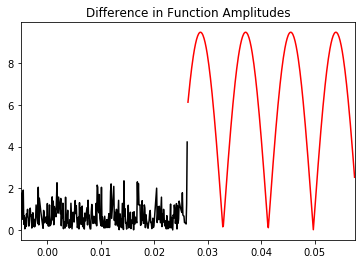

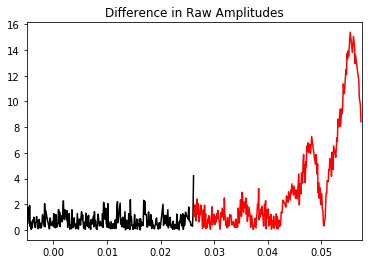

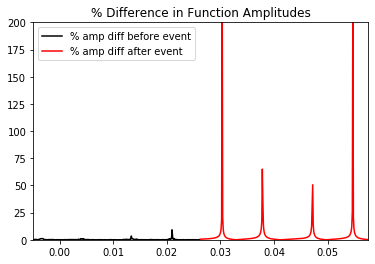

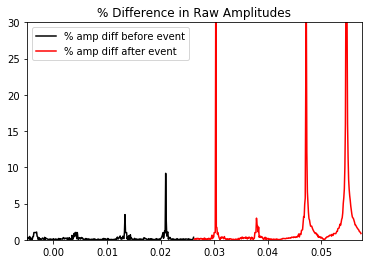

In [64]:
#4.A FAULT DETECTION: AMPLITUDE

ampSens = 5 #Input = sensitivity level (in Amperes). ~1A is fine.
percAmpSens = 1000 #Input = Sensitivity factor (in percentage). Anything above ~2% is fine for larger data sets.

def ampDiff(a,b):
    return np.abs(a-b)

def ampRat(a,b):
    return np.abs((a-b)/b) 

def initialFit(tmax):
    plt.plot(tt, ampDiff(yy, res["fitfunc"](tt)), "k-", label="amp diff before event")
    plt.plot(tt2, ampDiff(res["fitfunc"](tt), res["fitfunc"](tt2)), "r-", label="amp diff after event")
    plt.title("Difference in Function Amplitudes")
    plt.xlim(tBeg,tCur)
    plt.show()
    
    plt.plot(tt, ampDiff(yy, res["fitfunc"](tt)), "k-", label="amp diff before event")
    plt.plot(tt2, ampDiff(yy2, res["fitfunc"](tt2)), "r-", label="amp diff after event")
    plt.title("Difference in Raw Amplitudes")
    plt.xlim(tBeg,tCur)
    plt.show()
    
    plt.plot(tt, ampRat(yy, res["fitfunc"](tt)), "k-", label="% amp diff before event")
    plt.plot(tt2, ampRat(res["fitfunc"](tt), res["fitfunc"](tt2)), "r-", label="% amp diff after event")
    plt.legend(loc="best")
    plt.title("% Difference in Function Amplitudes")
    plt.xlim(tBeg,tCur)
    plt.ylim(0,200)
    plt.show()
    
    plt.plot(tt, ampRat(yy, res["fitfunc"](tt)), "k-", label="% amp diff before event")
    plt.plot(tt2, ampRat(yy2, res["fitfunc"](tt2)), "r-", label="% amp diff after event")
    plt.legend(loc="best")
    plt.title("% Difference in Raw Amplitudes")
    plt.xlim(tBeg,tCur)
    plt.ylim(0,30)
    plt.show()
    
initialFit(1)

In [65]:
#4.C PHASE SHIFT QUANTIFICATION

#print(fit_sin(tt, yy))
#print(fit_sin_new(tt, yy))

phase = "%(phase)s" %res
phase2 = "%(phase2)s" %res2
#print(phase,phase2)

amp = "%(amp)s" %res
amp2 = "%(amp2)s" %res2
#print(phase,phase2)

omega = "%(omega)s" %res
omega2 = "%(omega2)s" %res2
#print(phase,phase2)

floatAmp=float(amp)
sciAmp = '%E' % floatAmp
#print(floatAmp,sciAmp)
floatAmp2=float(amp2)
sciAmp2 = '%E' % floatAmp2
#print(floatAmp2,sciAmp2)

floatOmega=float(omega)
sciOmega = '%E' % floatOmega
#print(floatOmega,sciOmega)
floatOmega2=float(omega2)
sciOmega2 = '%E' % floatOmega2
#print(floatOmega2,sciOmega2)

floatPhase=float(phase)
sciPhase = '%E' % floatPhase
#print(floatPhase,sciPhase)
floatPhase2=float(phase2)
sciPhase2 = '%E' % floatPhase2
#print(floatPhase2,sciPhase2)

radianShift = (floatPhase2-floatPhase+1)/np.pi
degreeShift = radianShift*180/np.pi

print("Phase difference =", radianShift, "pi, or", degreeShift, "degrees.")

Phase difference = -0.008709880764320584 pi, or -0.49903940785774914 degrees.


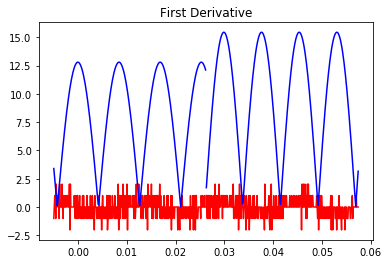

In [66]:
#5.A FIRST DERIVATIVES: Scaled for with sampling coefficient

#Using direct calculation

dyDir = np.zeros(len(tt-1))
for i in range (0,len(tt)-2):
    dyDir[i] = yy[i+1] - yy[i]
    
dyDir2 = np.zeros(len(tt2-1))
for i in range (0,len(tt2)-2):
    dyDir2[i] = yy2[i+1] - yy2[i]

#print(dyDir)

#Using calculus

dyCal= np.abs(floatAmp*floatOmega*np.cos(floatOmega*tt+0)/length)
dyCal2 = np.abs(floatAmp2*floatOmega2*np.cos(floatOmega2*tt2+.125*np.pi)/length)

#print (dyCal/sampCoeff)

plt.plot(tt, dyDir, "r-", label="Direct dy")
plt.plot(tt, dyCal, "b-", label="Calculus dy")
plt.plot(tt2, dyDir2, "r-", label="Direct dy")
plt.plot(tt2, dyCal2, "b-", label="Calculus dy")
plt.title("First Derivative")
plt.show()

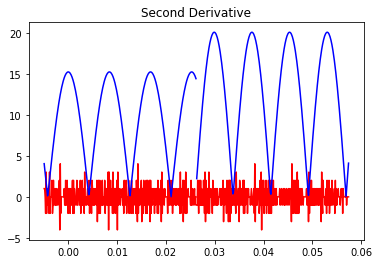

In [67]:
#5.B SECOND DERIVATIVES

#Using direct calculation

dydyDir = np.zeros(len(tt-1))
for i in range (0,len(tt)-2):
    dydyDir[i] = dyDir[i+1] - dyDir[i]
    
dydyDir2 = np.zeros(len(tt2-1))
for i in range (0,len(tt2)-2):
    dydyDir2[i] = dyDir2[i+1] - dyDir2[i]

#print(dyDir)

#Using calculus

dyCal= np.abs(floatAmp*floatOmega**2*np.cos(floatOmega*tt+0)/length**2)
dyCal2 = np.abs(floatAmp2*floatOmega2**2*np.cos(floatOmega2*tt2+.125*np.pi)/length**2)

#print (dyCal/sampCoeff)

plt.plot(tt, dydyDir, "r-", label="Direct dy")
plt.plot(tt, dyCal, "b-", label="Calculus dy")
plt.plot(tt2, dydyDir2, "r-", label="Direct dy")
plt.plot(tt2, dyCal2, "b-", label="Calculus dy")
plt.title("Second Derivative")
plt.show()

In [68]:
def diffAlert(diff):
    x = ampDiff(yy, res["fitfunc"](tt))
    for i in range (0,len(x)):
        if x[i]>diff:
            time = tMid-i/length
            print("ALERT: FALSE FAULT DETECTED",time, "SEC BEFORE FAULT")
    y = ampDiff(res2["fitfunc2"](tt2), res["fitfunc"](tt2))
    for i in range (0,len(y)):
        if y[i]>diff:
            time = tMid-i/length
            tElap = i/length
            print("ALERT: FAULT DETECTED",time, "SEC AGO,",tElap,"SEC AFTER FAULT OCCURED" )
            return time
            
#diffAlert(ampSens) 